In [1]:
import numpy as np
import struct
import array

In [6]:
img_len = 32
img_dim = 32 * 32
num_ch = 3
sample_per_file = 10000

# Tensor dim is [Batch, Channel, Row, Col]
train_batch_1 = np.empty([sample_per_file, num_ch, img_len, img_len], dtype=np.uint8)
label_batch_1 = np.empty(sample_per_file, dtype=np.uint8)

with open("cifar10/data_batch_1.bin", "rb") as f:
    for b in range(sample_per_file):
        label_batch_1[b] = struct.unpack("B", f.read(1))[0]
        for c in range(num_ch):
            img = np.array(array.array("B", f.read(img_dim)), dtype=np.uint8).reshape(img_len, img_len)
            train_batch_1[b,c,:,:] = img

<Figure size 640x480 with 0 Axes>

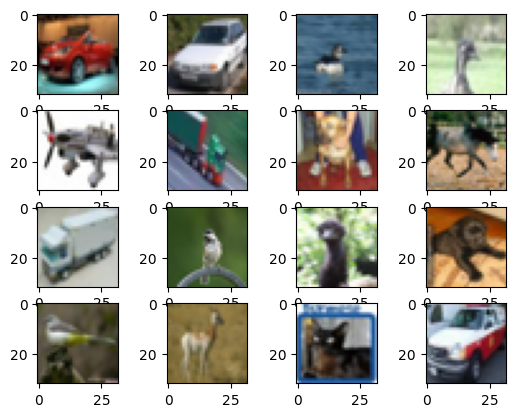

In [17]:
import matplotlib.pyplot as plt

plt.figure()

fig, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i][j].imshow(np.moveaxis(train_batch_1[45+4*i+j], 0, 2))

plt.show()

In [21]:
one_hot = lambda x, K : np.array(x[:,None] == np.arange(K)[None, :], dtype=int)
one_hot(np.array([3, 0, 1]), 10)

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [22]:
label_batch_1[432:432+20]

array([1, 7, 4, 4, 0, 6, 9, 0, 7, 8, 8, 9, 9, 3, 3, 4, 0, 4, 5, 6],
      dtype=uint8)

In [25]:
import micropip
await micropip.install("scipy")

In [33]:
"""Convolutional neural net on MNIST, modeled on 'LeNet-5',
http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf"""
from __future__ import absolute_import
from __future__ import print_function
from builtins import range

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.signal
from autograd import grad

from tqdm import trange, tqdm

convolve = autograd.scipy.signal.convolve

class WeightsParser(object):
    """A helper class to index into a parameter vector."""
    def __init__(self):
        self.idxs_and_shapes = {}
        self.N = 0

    def add_weights(self, name, shape):
        start = self.N
        self.N += np.prod(shape)
        self.idxs_and_shapes[name] = (slice(start, self.N), shape)

    def get(self, vect, name):
        idxs, shape = self.idxs_and_shapes[name]
        return np.reshape(vect[idxs], shape)

def make_batches(N_total, N_batch):
    start = 0
    batches = []
    while start < N_total:
        batches.append(slice(start, start + N_batch))
        start += N_batch
    return batches

def logsumexp(X, axis, keepdims=False):
    max_X = np.max(X)
    return max_X + np.log(np.sum(np.exp(X - max_X), axis=axis, keepdims=keepdims))

def make_nn_funs(input_shape, layer_specs, L2_reg):
    parser = WeightsParser()
    cur_shape = input_shape
    for layer in layer_specs:
        N_weights, cur_shape = layer.build_weights_dict(cur_shape)
        parser.add_weights(layer, (N_weights,))

    def predictions(W_vect, inputs):
        """Outputs normalized log-probabilities.
        shape of inputs : [data, color, y, x]"""
        cur_units = inputs
        for layer in layer_specs:
            cur_weights = parser.get(W_vect, layer)
            cur_units = layer.forward_pass(cur_units, cur_weights)
        return cur_units

    def loss(W_vect, X, T):
        log_prior = -L2_reg * np.dot(W_vect, W_vect)
        log_lik = np.sum(predictions(W_vect, X) * T)
        return - log_prior - log_lik

    def frac_err(W_vect, X, T):
        return np.mean(np.argmax(T, axis=1) != np.argmax(pred_fun(W_vect, X), axis=1))

    return parser.N, predictions, loss, frac_err

class conv_layer(object):
    def __init__(self, kernel_shape, num_filters):
        self.kernel_shape = kernel_shape
        self.num_filters = num_filters

    def forward_pass(self, inputs, param_vector):
        # Input dimensions:  [data, color_in, y, x]
        # Params dimensions: [color_in, color_out, y, x]
        # Output dimensions: [data, color_out, y, x]
        params = self.parser.get(param_vector, 'params')
        biases = self.parser.get(param_vector, 'biases')
        conv = convolve(inputs, params, axes=([2, 3], [2, 3]), dot_axes = ([1], [0]), mode='valid')
        return conv + biases

    def build_weights_dict(self, input_shape):
        # Input shape : [color, y, x] (don't need to know number of data yet)
        self.parser = WeightsParser()
        self.parser.add_weights('params', (input_shape[0], self.num_filters)
                                          + self.kernel_shape)
        self.parser.add_weights('biases', (1, self.num_filters, 1, 1))
        output_shape = (self.num_filters,) + \
                       self.conv_output_shape(input_shape[1:], self.kernel_shape)
        return self.parser.N, output_shape

    def conv_output_shape(self, A, B):
        return (A[0] - B[0] + 1, A[1] - B[1] + 1)

class maxpool_layer(object):
    def __init__(self, pool_shape):
        self.pool_shape = pool_shape

    def build_weights_dict(self, input_shape):
        # input_shape dimensions: [color, y, x]
        output_shape = list(input_shape)
        for i in [0, 1]:
            assert input_shape[i + 1] % self.pool_shape[i] == 0, \
                "maxpool shape should tile input exactly"
            output_shape[i + 1] = input_shape[i + 1] / self.pool_shape[i]
        return 0, output_shape

    def forward_pass(self, inputs, param_vector):
        new_shape = inputs.shape[:2]
        for i in [0, 1]:
            pool_width = self.pool_shape[i]
            img_width = inputs.shape[i + 2]
            new_shape += (img_width // pool_width, pool_width)
        result = inputs.reshape(new_shape)
        return np.max(np.max(result, axis=3), axis=4)

class full_layer(object):
    def __init__(self, size):
        self.size = size

    def build_weights_dict(self, input_shape):
        # Input shape is anything (all flattened)
        input_size = np.prod(input_shape, dtype=int)
        self.parser = WeightsParser()
        self.parser.add_weights('params', (input_size, self.size))
        self.parser.add_weights('biases', (self.size,))
        return self.parser.N, (self.size,)

    def forward_pass(self, inputs, param_vector):
        params = self.parser.get(param_vector, 'params')
        biases = self.parser.get(param_vector, 'biases')
        if inputs.ndim > 2:
            inputs = inputs.reshape((inputs.shape[0], np.prod(inputs.shape[1:])))
        return self.nonlinearity(np.dot(inputs[:, :], params) + biases)

class tanh_layer(full_layer):
    def nonlinearity(self, x):
        return np.tanh(x)

class softmax_layer(full_layer):
    def nonlinearity(self, x):
        return x - logsumexp(x, axis=1, keepdims=True)


# Network parameters
L2_reg = 1.0
input_shape = (num_ch, img_len, img_len)
layer_specs = [conv_layer((3, 3), 6),
                maxpool_layer((3, 3)),
                conv_layer((3, 3), 16),
                maxpool_layer((2, 2)),
                tanh_layer(120),
                tanh_layer(84),
                softmax_layer(10)]

# Training parameters
param_scale = 0.1
learning_rate = 1e-3
momentum = 0.9
batch_size = 256
num_epochs = 3

# Load and process MNIST data
print("Loading training data...")
add_color_channel = lambda x : x.reshape((x.shape[0], 1, x.shape[1], x.shape[2]))
one_hot = lambda x, K : np.array(x[:,None] == np.arange(K)[None, :], dtype=int)

train_images = train_batch_1 / 255.0

train_labels = one_hot(label_batch_1, 10)

N_data = train_images.shape[0]

# Make neural net functions
N_weights, pred_fun, loss_fun, frac_err = make_nn_funs(input_shape, layer_specs, L2_reg)
loss_grad = grad(loss_fun)

# Initialize weights
rs = npr.RandomState()
W = rs.randn(N_weights) * param_scale

# Check the gradients numerically, just to be safe
# quick_grad_check(loss_fun, W, (train_images[:50], train_labels[:50]))

#print("    Epoch      |    Train err  |   Test error  ")
def print_perf(epoch, W):
    #test_perf  = frac_err(W, test_images, test_labels)
    train_perf = 0.0
    for i in range(5):
        train_perf += frac_err(W, train_images[2000*i:2000*(i+1)], train_labels[2000*i:2000*(i+1)])
    print("Accuracy: {0:15}".format(1.0-(train_perf/5.0)))

# Train with sgd
batch_idxs = make_batches(N_data, batch_size)
cur_dir = np.zeros(N_weights)

for epoch in trange(num_epochs, desc="Epoch"):
    print_perf(epoch, W)
    for idxs in tqdm(batch_idxs, desc="Minibatch"):
        grad_W = loss_grad(W, train_images[idxs], train_labels[idxs])
        cur_dir = momentum * cur_dir + (1.0 - momentum) * grad_W
        W -= learning_rate * cur_dir

Loading training data...


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 0.10009999999999997



Epoch:  33%|███▎      | 1/3 [01:55<03:51, 115.73s/it]

Accuracy: 0.2967000000000001



Epoch:  67%|██████▋   | 2/3 [03:59<02:00, 120.53s/it]

Accuracy: 0.35420000000000007



Epoch: 100%|██████████| 3/3 [05:55<00:00, 118.63s/it]


In [35]:
print_perf(3, W)

Accuracy: 0.41190000000000004


In [36]:
#print("    Epoch      |    Train err  |   Test error  ")
def print_perf(epoch, W):
    #test_perf  = frac_err(W, test_images, test_labels)
    train_perf = 0.0
    for i in trange(5, desc="Eval"):
        train_perf += frac_err(W, train_images[2000*i:2000*(i+1)], train_labels[2000*i:2000*(i+1)])
    print("Accuracy: {0:15}".format(1.0-(train_perf/5.0)))

# Train with sgd
batch_idxs = make_batches(N_data, batch_size)
cur_dir = np.zeros(N_weights)

for epoch in trange(num_epochs, desc="Epoch"):
    print_perf(epoch, W)
    for idxs in tqdm(batch_idxs, desc="Minibatch"):
        grad_W = loss_grad(W, train_images[idxs], train_labels[idxs])
        cur_dir = momentum * cur_dir + (1.0 - momentum) * grad_W
        W -= learning_rate * cur_dir

Eval: 100%|██████████| 5/5 [00:34<00:00,  6.90s/it]


Accuracy: 0.41190000000000004



Eval: 100%|██████████| 5/5 [00:33<00:00,  6.68s/it]


Accuracy: 0.43409999999999993



Eval: 100%|██████████| 5/5 [00:32<00:00,  6.57s/it]


Accuracy: 0.45609999999999995



Epoch: 100%|██████████| 3/3 [05:24<00:00, 108.14s/it]


In [40]:
mylabels = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

Predicted: ship, Ground Truth: ship


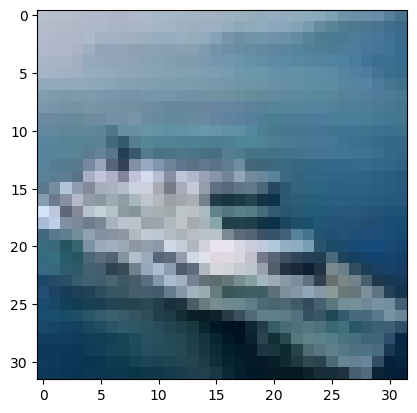

In [53]:
instance_id = 7610

plt.imshow(np.moveaxis(train_batch_1[instance_id], 0, 2))
ground_truth = mylabels[label_batch_1[instance_id]]
predicted_label = mylabels[np.argmax(pred_fun(W, train_batch_1[instance_id:instance_id+1]), axis=1)[0]]
print("Predicted: {pr}, Ground Truth: {gr}".format(pr=predicted_label, gr=ground_truth))